# Projet Cassiopée : Prédiction de virulence de Cancer

## Sommaire

[1. Imports python](#Imports-python)

[2. Présentation du projet](#Présentation-du-projet)

[3. Présentation des données](#Présentation-des-données)
   + [3.1 Import des données](#Import-des-données)
      * [3.1.1 Base Epilung](#Base-Epilung)
         - [3.1.1.1 Données cliniques](#Données-cliniques)
         - [3.1.1.1 Données transcriptomiques](#Données-transcriptomiques)
      * [3.1.1 Base NSCLC](#Base-NSCLC)
         - [3.1.1.1 Données cliniques](#Base-NSCLC)
         - [3.1.1.1 Données transcriptomiques](#aTrscrNSCLC)
      * [3.1.1 Base CLCGP](#Base-CLCGP)
         - [3.1.1.1 Données cliniques](#Base-CLCGP)
         - [3.1.1.1 Données transcriptomiques](#aTrscrCLCGP)
         
         
   + [3.2 Analyse univariée](#Analyse-univariée)
      * [3.2.1 Base epilung](#univarEpi)
         - [3.1.1.1 Données cliniques](#univarEpiclin)
         
         
   + [3.3 Feature engineering](#Feature-Engineering)
      * [3.3.1 Base epilung](#featEpi)
         - [3.3.1.1 Données cliniques](#featEpiclin)

[4. Modèles GLM](#Régression-Logistique)
   + [4.1 Preuve de concept : Détermination de l'histologie](#Preuve-de-concept-:-Détermination-de-l'histologie)
      * [4.1.1 Cas biclasse](#Cas-biclasse)
      * [4.1.1 Cas multiclasse](#Cas-multiclasse)
      
      
   + [4.2 Prédiction du taux de survie à n mois](#Prédiction-du-taux-de-survie-à-n-mois)
   
   
   + [4.3 Prédiction de la durée de survie](#Prédiction-de-la-durée-de-survie)

## Imports python

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [21]:
import Bite

In [8]:
import Traitement as proc

## Présentation du projet

L'objectif de ce projet est de fournir un outil précis de prédiction de taux de mortalité pour le cancer, en se basant sur des données transcriptomiques. Pour cela, nous allons test différentes méthodes d'aprentissage automatique afin d'obtenir le meilleur taux de prédiction.

### Survie

TODO : déterminer ce que l'on cherche à prédire

Séparer en approches ? Prise en compte du modèle de Cox ?

    > Basique : décès ou survie au bout de x mois
    > Avancée : prendre en compte la cause du décès : s'intéresser à la rechute (relapse)

### Métrique de performances

Ici comme on cherche à prédire un taux de surive compris entre 0 et 1, la métrique utilisée sera celle de la perte logarithmique



## Présentation des données

### Import des données

On utilise au cours du projet plusieurs bases de données afin d'entraîner et tester nos modèles

On définit des constantes pour harmoniser les appellations entre les bases

In [5]:
HISTOLOGY = "histology"
SEX = "sex"
ID = "id"
AGE = "age"
OS = "Overall survival"
EFS = "Event Free Survival"
PATHOLOGY = "pathology"
DEAD = "dead"

On définit des méthodes pour le traitement des données

In [5]:
def refining_expGrp(base,keep,rename,dropna_col,index_col=None):
    XpG = pd.read_csv(base+r'/'+base+'_exp_grp.csv',index_col=index_col)
    XpG = XpG[keep]
    XpG = XpG.rename(index=str,columns=rename)
    XpG = XpG.dropna(axis=0,subset=dropna_col)
    return XpG

def refining_trscr(base,transpose=False):
    Trscr = pd.read_csv(base+r'/'+base+'_data.csv',index_col=0)
    if transpose:
        Trscr = Trscr.transpose()
    return Trscr

def refining_platform(base,keep,rename,dtype):
    Plt = pd.read_csv(base+r'/'+base+'_platform.csv',dtype=dtype)
    Plt = Plt[Plt['SPOT_ID']!='--Control']
    Plt = Plt[keep]
    Plt = Plt.rename(index=str,columns=rename)
    return Plt

#### Base Epilung

La base epilung concerne 660 échantillons, dont 353 proviennent de tissus tumoraux

A chaque échantillon est associé 
    - Des données cliniques concernant le patient
    - Un profil d'expression transcriptomique réalisé avec 54675 probes
    - Un profil de méthylation
    


Nous allons maintenant nous intéresser aux données

In [10]:
base = "epilung"

##### Données cliniques

In [88]:
keep = ['id_sample','sex','age_min','age_max','id_topology','id_topology_group','id_morphology','id_pathology','t','n','m','tnm_stage','dfs_months','os_months','relapsed','dead','treatment','exposure','index_histology_code','efs','os','lof_gof']
rename = {"id_sample":ID,"age_min":AGE,"index_histology_code":HISTOLOGY,'os':OS,"id_pathology":PATHOLOGY,'efs':EFS,'dead':DEAD}
dropna = [HISTOLOGY,PATHOLOGY]

In [89]:
XpG = refining_expGrp(base=base,keep=keep,rename=rename,dropna_col=dropna)

Exportons maintenant ce dataframe

In [90]:
XpG.to_csv(base+r'/'+base+'_XpG_refined.csv',index=False)

##### Données transcriptomiques

In [42]:
Trscr = refining_trscr(base=base,transpose=True)

On exporte le dataframe

In [43]:
Trscr.to_csv(base+r'/'+base+'_trscr.csv')

##### Plateforme 

In [55]:
keep = ['ID','GB_ACC','Gene Symbol','ENTREZ_GENE_ID','RefSeq Transcript ID']
rename = {'ID':ID}
dtype={'SPOT_ID':str}

In [61]:
Plt = refining_platform(base=base,keep=keep,rename=rename,dtype=dtype)

In [62]:
Plt.to_csv(base+r'/'+base+'_platform-refined.csv',index=False)

#### Base NSCLC

In [46]:
base = "nsclc"

##### Données cliniques

In [47]:
keep = ['id','Characteristics..sex.','Characteristics..age.','Characteristics.individual.','histo']
rename = {'Characteristics..sex.':SEX,'Characteristcs..age.':AGE,'histo':HISTOLOGY}

In [51]:
XpG = refining_expGrp(base=base,keep=keep,rename=rename)

Exportons maintenant ce dataframe

In [52]:
XpG.to_csv(base+r'/'+base+'_XpG_refined.csv',index=False)

##### Données transcriptomiques

In [53]:
Trscr = refining_trscr(base=base,transpose=True)

On exporte le dataframe

In [54]:
Trscr.to_csv(base+r'/'+base+'_trscr.csv')

<a id = "aTrscrNSCLC"></a>

#### Base CLCGP

In [55]:
base = "clcgp"

##### Données cliniques

In [56]:
XpG = pd.read_csv(base+r'/'+base+'_exp_grp.csv')

In [57]:
XpG.shape

(261, 95)

On a donc bien 660 échantillons, avec 62 variables par échantillon

Nous allons nous intéresser à une quantité de limitée de variables

In [69]:
keep = ['Histo_final','Sex_ori','Age.Diagnosis']
rename = {'Histo_final':HISTOLOGY,'Sex_ori':SEX,'Age.Diagnosis':AGE}

In [72]:
XpG = refining_expGrp(base=base,keep=keep,rename=rename,index_col=0)

In [106]:
XpG_refined = XpG[['id_sample','sex','age_min','age_max','id_topology','id_topology_group','id_morphology','t','n','m','tnm_stage','dfs_months','os_months','relapsed','dead','treatment','exposure','index_histology_code','efs','os','lof_gof']]

Exportons maintenant ce dataframe

In [111]:
XpG_refined.to_csv(base+r'/'+base+'_XpG_refined.csv',index=False)

<a id = "aTrscrCLCGP"></a>

### Analyse univariée

<a id = "univarEpi"></a>

#### Base epilung

<a id = "univarEpiclin"></a>

In [4]:
Clinique = pd.read_csv("epilung/XpG_refined.csv",index_col='id_sample')

In [5]:
Clinique_sain = Clinique['index_histology_code'].isnull()
Clinique_malade = Clinique_sain.isin([False])

Index_sain = Clinique_sain.loc[Clinique_sain].index.values
Index_malade = Clinique_malade.loc[Clinique_malade].index.values

In [6]:
F_malade = (Clinique['sex'].loc[Index_malade].values == 'F').sum()
M_malade = (Clinique['sex'].loc[Index_malade].values == 'M').sum()
nan_malade = Clinique['sex'].loc[Index_malade].shape[0]-F_malade-M_malade
malade = [F_malade,M_malade,nan_malade]

In [7]:
F_sain = (Clinique['sex'].loc[Index_sain].values == 'F').sum()
M_sain = (Clinique['sex'].loc[Index_sain].values == 'M').sum()
nan_sain = Clinique['sex'].loc[Index_sain].shape[0]-F_sain-M_sain
sain = [F_sain,M_sain,nan_sain]

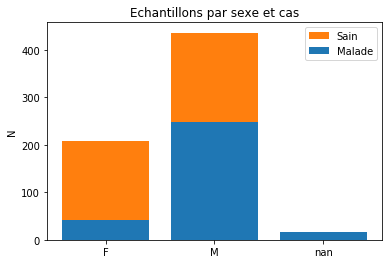

In [116]:
p1 = plt.bar(np.arange(3),malade)
p2 = plt.bar(np.arange(3),sain,bottom=malade)

plt.ylabel('N')
plt.title('Echantillons par sexe et cas')
plt.xticks(np.arange(3),('F','M','nan'))
plt.legend((p2[0],p1[0]),('Sain','Malade'))
plt.show()

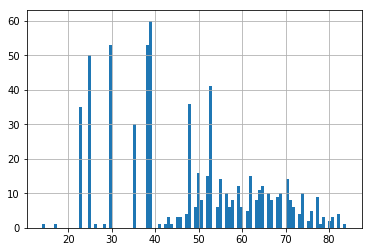

In [117]:
Clinique['age_min'].hist(bins=100)
plt.show()

/home/merlin/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


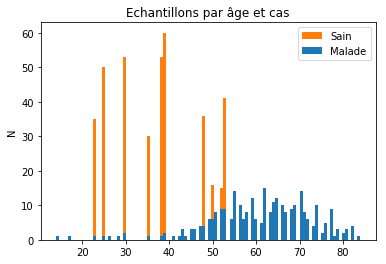

In [118]:
plt.hist([Clinique['age_min'].loc[Index_malade].dropna(),Clinique['age_min'].loc[Index_sain].dropna()],bins=100,stacked=True)
plt.ylabel('N')
plt.title('Echantillons par âge et cas')
plt.legend((p2[0],p1[0]),('Sain','Malade'))
plt.show()

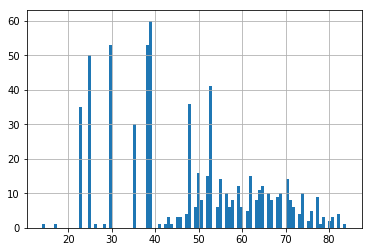

In [25]:
Clinique['age_max'].hist(bins=100)
plt.show()

In [119]:
def barsplot(df,titre='',figsize=(6,4)):
    
    valeurs = df.unique()
    
    categories_sain = []
    categories_malade = []
    
    for v in valeurs:
        
        if pd.isnull(v):
            categories_sain.append(Clinique['id_pathology'].loc[Index_sain].apply(pd.isnull).sum())
            categories_malade.append(Clinique['id_pathology'].loc[Index_malade].apply(pd.isnull).sum())
        else:
            categories_malade.append((df.loc[Index_malade].values == v).sum())
            categories_sain.append((df.loc[Index_sain].values == v).sum())

    index = np.arange(valeurs.shape[0])
    
    fig=plt.figure(figsize=figsize)
    
    p1 = plt.bar(index,categories_malade)
    p2 = plt.bar(index,categories_sain,bottom=categories_malade)

    plt.ylabel('N')
    plt.title(titre)
    plt.xticks(index,valeurs)
    plt.legend((p2[0],p1[0]),('Sain','Malade'))
    plt.show()

In [ ]:
barsplot(Clinique['id_tissue_status'],'')

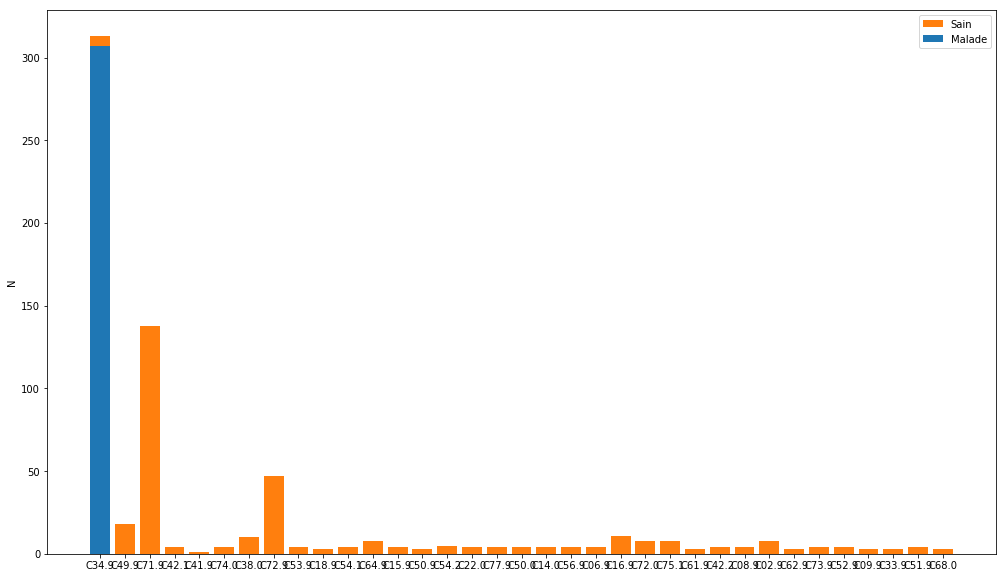

In [30]:
barsplot(Clinique['id_topology'],'',(17,10))

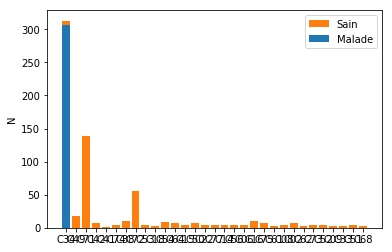

In [31]:
barsplot(Clinique['id_topology_group'],'')

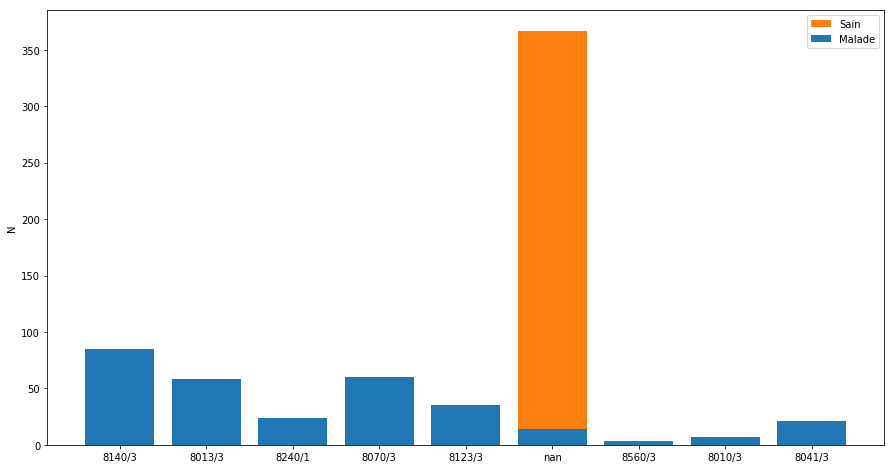

In [32]:
barsplot(Clinique['id_morphology'],'',(15,8))

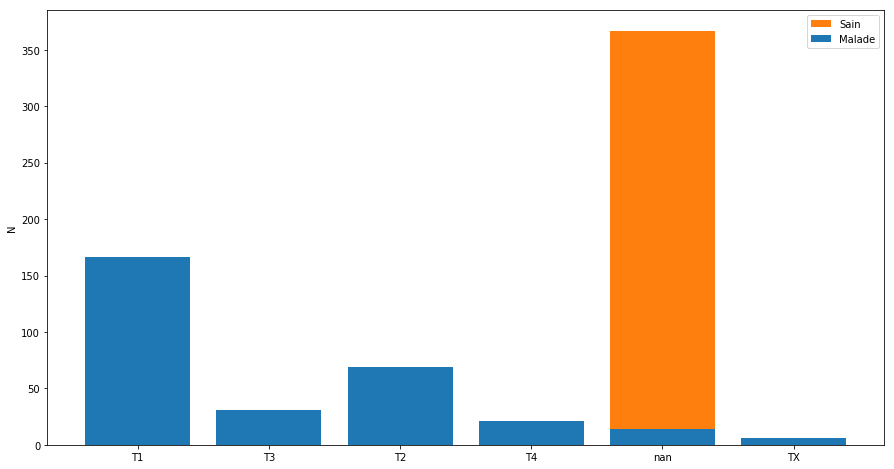

In [33]:
barsplot(Clinique['t'],'',(15,8))

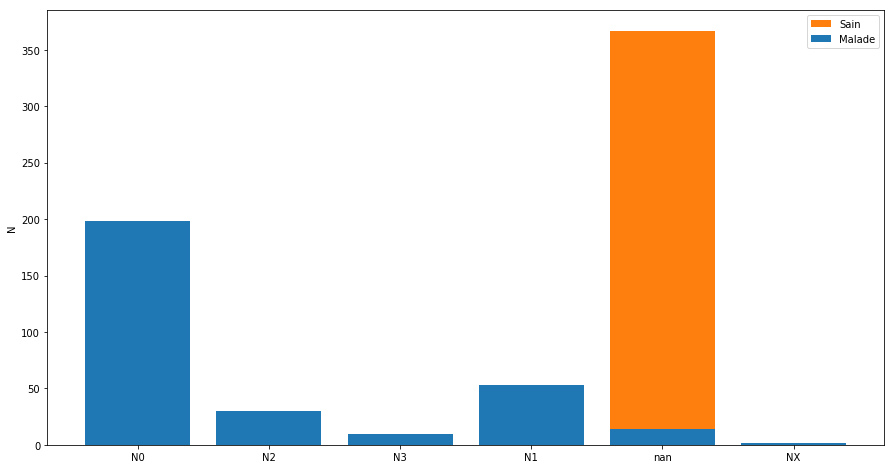

In [34]:
barsplot(Clinique['n'],'',(15,8))

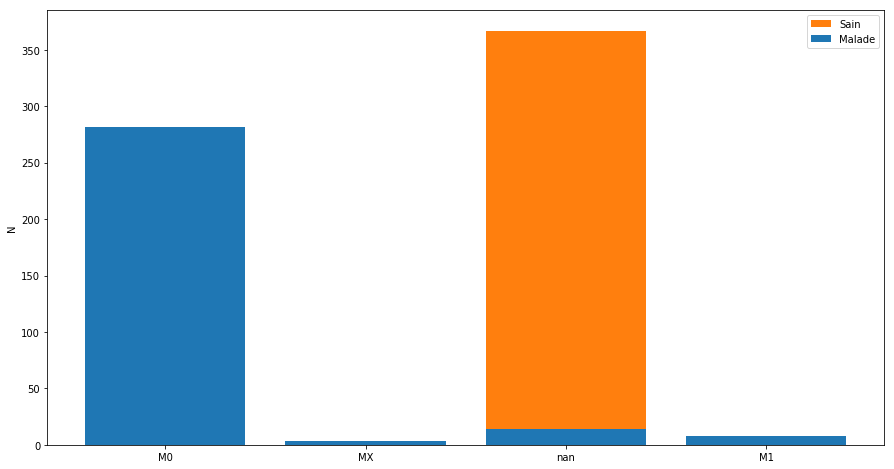

In [35]:
barsplot(Clinique['m'],'',(15,8))

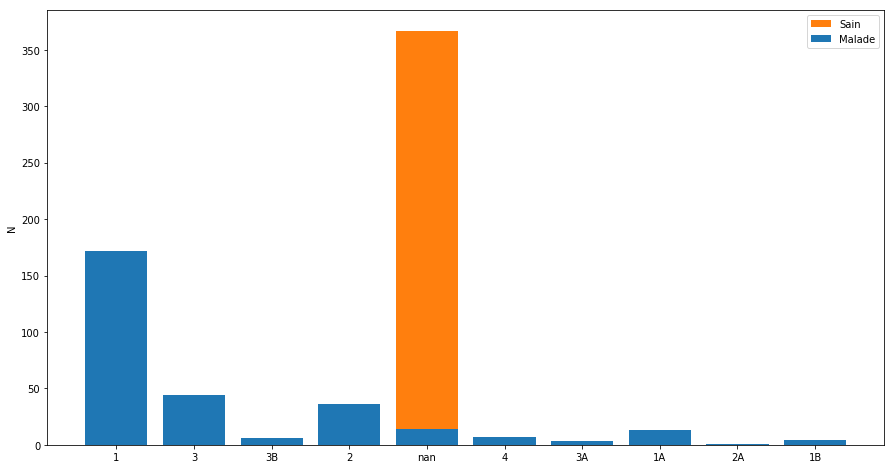

In [36]:
barsplot(Clinique['tnm_stage'],'',(15,8))

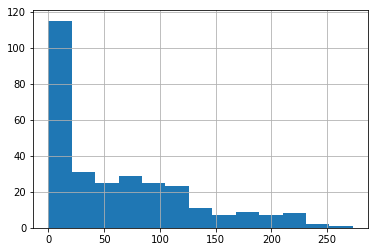

In [37]:
Clinique['dfs_months'].hist(bins=13)
plt.show()

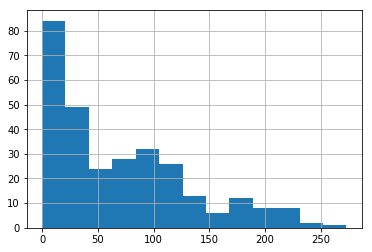

In [38]:
Clinique['os_months'].hist(bins=13)
plt.show()

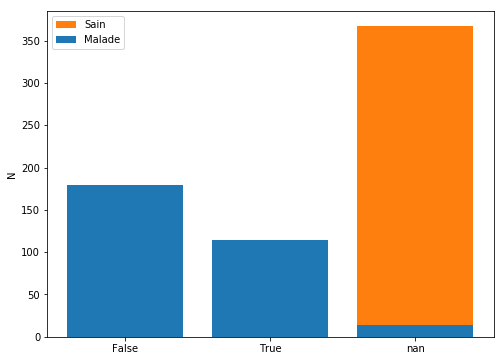

In [39]:
barsplot(Clinique['relapsed'],'',(8,6))

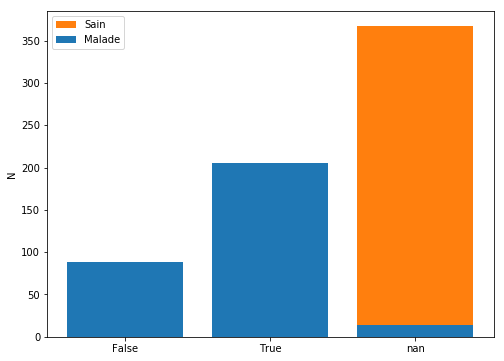

In [40]:
barsplot(Clinique['dead'],'',(8,6))

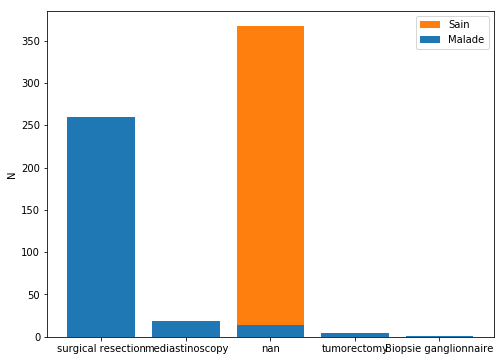

In [41]:
barsplot(Clinique['treatment'],'',(8,6))

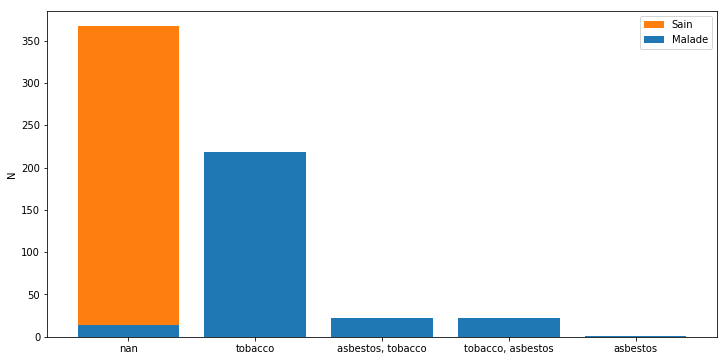

In [42]:
barsplot(Clinique['exposure'],'',(12,6))

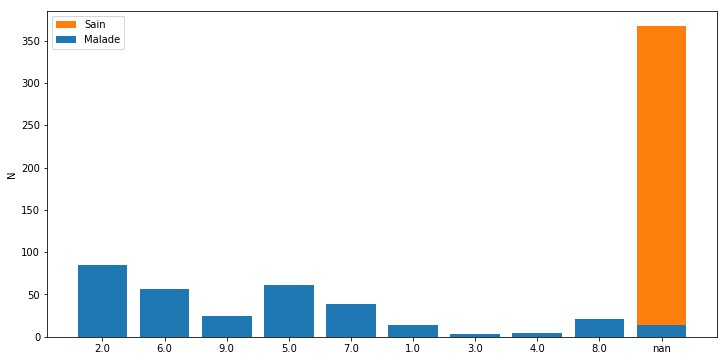

In [43]:
barsplot(Clinique['index_histology_code'],'',(12,6))

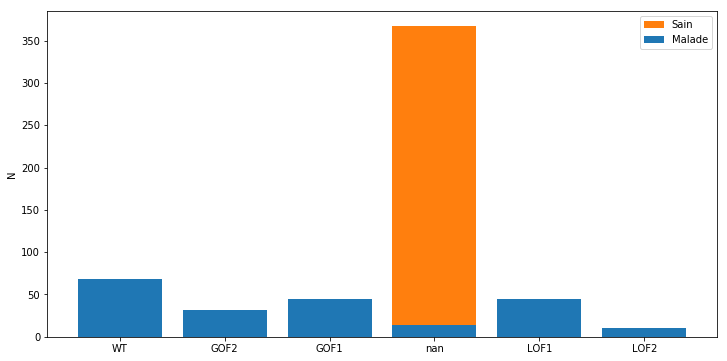

In [44]:
barsplot(Clinique['lof_gof'],'',(12,6))

#### Base NSCLC

In [35]:
base = "nsclc"

In [217]:
Clinique = pd.read_csv(base+r"/"+base+"_XpG_refined.csv",index_col='id')

### Feature Engineering

In [211]:
def OHEncoding(filename,categorical_columns):
    DF = pd.read_csv(filename,index_col=ID)
    DF = pd.get_dummies(DF,columns=categorical_columns)
    return DF

def Create_Patient_Index_Regression(df):
    return df[DEAD].index.values

def Create_Patient_Drop_Index_Classification(df,n_mois):
    I = [(k[-1]=='+' and int(k[:-1])<n_mois) for k in df[OS].values]
    return np.setdiff1d(df.index.values,I)

def X_transcriptome(base,index):
    X = pd.read_csv(base+r'/'+base+'_trscr.csv',index_col=0)
    return X.loc[index]

def get_function_survival(n_mois):
    return lambda x: 1 if x[-1]=='+' else int((int(x) > n_mois))

def Y_clinique(base,index,n_mois=None):
    Y = pd.read_csv(base+r'/'+base+'_clinique_OH.csv',index_col=0)
    Y = Y.loc[index]
    if n_mois is None:
        Y = Y['os_months']
    else:
        Y = Y[OS].apply(get_function_survival(n_mois))
    return Y

<a id = "featEpi"></a>

#### Base epilung

In [5]:
base = "epilung"

<a id = "featEpiclin"></a>

On réalise un one-hot encoding sur les variables catégoriques

In [220]:
categorical_columns = [SEX,'id_topology','id_topology_group','id_morphology','t','n','m','tnm_stage','treatment','exposure',HISTOLOGY,'lof_gof']
filename = base+r'/'+base+'_XpG_refined.csv'

In [223]:
Clinique_OH = OHEncoding(filename,categorical_columns)

In [224]:
Clinique_OH.to_csv(base+r'/'+base+'_clinique_OH.csv')

Création des index des patients que l'on utilisera pour la régression et la classification

In [221]:
nmois = 60

In [20]:
Index_regression = Create_Patient_Index_Regression(Clinique_OH)

In [225]:
Index_classification = Create_Patient_Drop_Index_Classification(Clinique_OH,nmois)

On créé nos dataframes X et Y pour les deux cas

In [173]:
X_r = X_transcriptome(base,Index_regression)

In [226]:
X_nmois = X_transcriptome(base,Index_classification)

In [175]:
Y_r = Y_clinique(base,Index_regression)

In [227]:
Y_nmois = Y_clinique(base,Index_classification,nmois)

On exporte les X et Y construits

In [177]:
X_r.to_csv(base+r'/X_regression.csv')

In [178]:
Y_r.to_csv(base+r'/Y_regression.csv')

In [228]:
X_nmois.to_csv(base+rf'/X_classification-{nmois}.csv')

In [229]:
Y_nmois.to_csv(base+rf'/Y_classification-{nmois}.csv')

# Régression Logistique

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

## Preuve de concept : Détermination de l'histologie

On cherche ici à déterminer l'histologie (le type de cancer), à partir des données transcriptomiques seulement.

En plus de la perte logarithmique on peut s'intéresser au taux de succès, cependant cet indicateur a un intérêt limité, car il n'est que peu lié à l'erreur commise par notre estimateur

### Pénalisation

On remarque rapidement que nous avons beaucoup plus de variables que de données. En effet, nous disposns de plus de 50 000 variables transcriptomiques, avec seulement 300 patients atteint de cancer.

Cela a un impact sur les performances de la régression GLM : en effet il faut déterminer un coefficient par variable. Or lorsqu'on a moins de points de données que de paramètres à estimer, les coefficients déterminés par le modèle vont trop dépendre des données.

Concrètement, lorsque l'on effectue une régression GLM, on résoud un problème d'optimisation : minimiser l'erreur quadratique moyenne entre une fonction et les données. Or dans le cas ou on dispose de plus de variables que de donénes, il existe une infinité de manière de choisir les coefficients tels qu'on minimise l'erreur quadratique moyenne. Dans notre cas on cherche à choisir les coefficients qui sont les plus performants en généralisation.

Pour régler cela, on fait appel à la pénalisation, aussi appellée régularisation. Cela correspond à changer le problème d'optimisation en ajoutant un terme qui modifie le problème, en incluant un terme qui dépend du vecteur de coefficients. Quand on résoud le problème d'optimisation, on cherchera donc des solutions qui minimisent l'erreur quadratique plus la norme en question. On choisit en général d'utiliser une norme du vecteur de coefficients. 

On parle de pénalisation ridge pour la norme 2, qui a pour effet de diminuer les valeurs du vecteur de coefficients.

On parle de pénalisation lasso pour la norme 1, qui a pour effet de mettre les valeurs de certains coefficients à zéro.

La pénalisation permet de gagner en généralisation en appliquant le principe du rasoir d'Occam : on privilégie les solutions les moins spécifiques.

### Cas biclasse

Dans le cas présent on ne s'intéresse que aux deux histologies les plus fréquentes dans notre jeux de données : ADK (type 2), et SQC (type 5).

In [191]:
Y = pd.read_csv(base+r"/"+base+'_XpG_refined.csv',usecols=[ID,HISTOLOGY],index_col=0)
Y = Y.loc[(Y[HISTOLOGY] == 2) | (Y[HISTOLOGY] == 5)]
Y.loc[:,HISTOLOGY] = Y.loc[:,HISTOLOGY].apply(lambda x: int(x>3))

X = pd.read_csv(base+r"/"+base+'_trscr.csv',index_col=0)
X = X.loc[Y.index.values]

On va maintenant tester l'approche la plus basique, avec une simple division apprentissage/test

In [192]:
Xtrain = X.iloc[73:]
Ytrain = Y.iloc[73:]

Xtest = X.iloc[:73]
Ytest = Y.iloc[:73]

On teste les performances de la régression logistique avec les pénalisations norme 1 et 2

In [195]:
LogR2 = LogisticRegression(penalty="l2")
LogR1 = LogisticRegression(penalty="l1")

In [207]:
LogR2.fit(Xtrain,Ytrain[HISTOLOGY])
LogR1.fit(Xtrain,Ytrain[HISTOLOGY])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

On peut obtenir facilement le pourcentage de classifications correctes, ainsi que la perte logarithmique

In [208]:
LogR2.score(Xtest,Ytest)

0.9726027397260274

In [209]:
log_loss(Ytest,LogR2.predict(Xtest))/Xtest.shape[0]

0.01296257323884808

In [210]:
LogR1.score(Xtest,Ytest)

0.9726027397260274

In [211]:
log_loss(Ytest,LogR1.predict(Xtest))/Xtest.shape[0]

0.01296257323884808

#### Validation croisée

On met maintenant en oeuvre la validation croisée afin d'obtenir des résultats indépendants de la division apprentissage/test de notre jeu de données.

On commence par définir des fonctions qui permettent de calculer la moyenne de la perte logarithmique et du score sur N itérations de validation croisée.

In [4]:
def logloss_cv(X=None,Y=None,classifier=None,cv=None):
    kf = cv.split(X,Y)
    loss = 0
    for i in range(cv.get_n_splits()):
        IndexTrain,IndexTest = next(kf)
        Xtrain,Ytrain = X.iloc[IndexTrain],Y.iloc[IndexTrain]
        Xtest,Ytest = X.iloc[IndexTest],Y.iloc[IndexTest]
        classifier.fit(Xtrain,Ytrain)
        loss += log_loss(Ytest,classifier.predict(Xtest))
    return loss/X.shape[0]

In [5]:
def avg_logloss_cv(X=None,Y=None,classifier=None,cv=None,N=100):
    moy = 0
    for i in range(N):
        moy += logloss_cv(X,Y,classifier,cv)
    return moy/N

In [6]:
def score_cv(X=None,Y=None,classifier=None,cv=None):
    kf = cv.split(X,Y)
    score = 0
    for i in range(cv.get_n_splits()):
        IndexTrain,IndexTest = next(kf)
        Xtrain,Ytrain = X.iloc[IndexTrain],Y.iloc[IndexTrain]
        Xtest,Ytest = X.iloc[IndexTest],Y.iloc[IndexTest]
        classifier.fit(Xtrain,Ytrain)
        score += classifier.score(Xtest,Ytest)
    return score/cv.get_n_splits()

In [7]:
def avg_score_cv(X=None,Y=None,classifier=None,cv=None,N=100):
    moy = 0
    for i in range(N):
        moy += score_cv(X,Y,classifier,cv)
    return moy/N

On utilise ici la validation croisée KFold, en divisant notre base de données en 5.

Le principe de la KFold est de diviser la base en $n$ sous-bases, et de moyenner la perte sur $n$ essais, en choisissant comme base de test la $k^e$ sous-base, et en joignant le reste des bases pour former la base d'apprentissage. Cela permet d'obtenir des scores plus fiables, car beaucoup moins dépendant de la manière dont effectue la séparation entre base d'apprentissage et base de test par rapport à l'approche classique.

On utilisera les modèles de régression logistique avec les deux pénalisations.

In [13]:
kfold = KFold(n_splits = 5,shuffle=True)

On commence par tester à nouveau les performances des deux pénalisations, moyennées sur 100 validations croisées

In [21]:
avg_logloss_cv(X=X,Y=Y[HISTOLOGY],cv=kfold,classifier=LogR2)

0.029122315863983606

In [22]:
avg_score_cv(X=X,Y=Y[HISTOLOGY],cv=kfold,classifier=LogR2)

0.97483908045976986

In [29]:
avg_logloss_cv(X=X,Y=Y[HISTOLOGY],cv=kfold,classifier=LogR1)

0.024306575515202863

In [30]:
avg_score_cv(X=X,Y=Y[HISTOLOGY],cv=kfold,classifier=LogR1)

0.97947356321839107

On remarque qu'en moyenne, la pénalisation norme 1 est plus efficace, ce qui est attendu car on a beacoup de variables qui ont un impact faible : le coefficient de la régression qui leur est associé vaut alors 0.

On va maintenant utiliser ce principe afin de sélectionner le set de variables qui minimise la perte.

Pour cela, on va effectuer 100 validations croisées, et à chaque fois que l'on adapte notre modèle à la base d'apprentissage (soit 5 fois par validation croisée), l'on va incrémenter un compteur.

On obtient alors un vecteur qui contient pour chaque variable le pourcentage de cas où la régression penalisée en norme 1 lui a associé un coefficient non nul. A l'aide de ce vecteur on va pouvoir choisir un seuil entre 0 et 1 et retirer les composantes dont le pourcentage d'occurence est inférieur au seuil.

In [8]:
def get_important_parameters():
    classifier=LogisticRegression(penalty="l1")
    kfold = KFold(n_splits=5,shuffle=True)
    coefs = np.zeros(X.shape[1])
    for k in range(100):
        #print(f"{k}%")
        kf = kfold.split(X,Y)
        for i in range(5):
            IndexTrain,IndexTest = next(kf)
            Xtrain,Ytrain = X.iloc[IndexTrain],Y.iloc[IndexTrain]
            Xtest,Ytest = X.iloc[IndexTest],Y.iloc[IndexTest]
            classifier.fit(Xtrain,Ytrain)
            index = np.nonzero(classifier.coef_)[1]
            coefs[index]+=1/500
    return coefs

In [51]:
C = get_important_parameters()

0%


/home/merlin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%


Afin de déterminer le seuil optimal, on calcule la perte sur 100 validations croisées pour chaque valeur de seuil comprise entre 0 et 1, avec des incréments de 0.01. Le seuil qui minimisera la perte sera alors retenu.

In [9]:
def seuil(Array,S):
    f_s = lambda x: int(x > S)
    f = np.vectorize(f_s)
    return f(Array)

In [52]:
x = np.arange(0,1,0.01)
y = []
for k in x:
    Index_k = np.nonzero(seuil(C,k))[0]
    Xk = X.iloc[:,Index_k]
    y.append(avg_logloss_cv(X=Xk,Y=Y[HISTOLOGY],cv=kfold,classifier=LogR2))

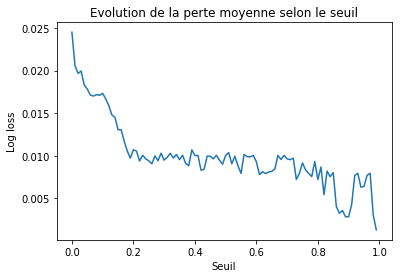

In [53]:
plt.plot(x,y)
plt.ylabel("Log loss")
plt.xlabel("Seuil")
plt.title("Evolution de la perte moyenne selon le seuil")
plt.show()

On obtient que le seuil optimal est 0.9, avec une perte logarithmique associée de 0.003.

In [54]:
x[np.argmin(y)]

0.98999999999999999

In [56]:
avg_logloss_cv(X=X90,Y=Y[HISTOLOGY],cv=kfold,classifier=LogR2)

0.0030101106494383983

On calcule un score moyen sur 100 validations croisées de 99.8% de classifications correctes

In [57]:
avg_score_cv(X=X90,Y=Y[HISTOLOGY],cv=kfold,classifier=LogR2)

0.99815862068965511

On récupère les noms des sondes que l'on a gardé avec un seuil à 0.9

In [55]:
Index_90 = np.nonzero(seuil(C,x[90]))[0]
X90 = X.iloc[:,Index_90]

X.iloc[:,Index_90].dtypes.index.values

array(['201820_at', '203074_at', '203757_s_at', '203824_at', '203953_s_at',
       '204455_at', '204855_at', '204920_at', '205549_at', '205776_at',
       '206165_s_at', '206166_s_at', '206239_s_at', '206884_s_at',
       '208168_s_at', '210020_x_at', '210505_at', '210674_s_at',
       '211024_s_at', '211756_at', '213796_at', '213992_at', '215125_s_at',
       '217272_s_at', '217528_at', '217564_s_at', '218858_at',
       '218990_s_at', '221796_at', '226226_at', '226755_at', '227174_at',
       '227194_at', '229290_at', '230323_s_at', '231315_at', '232202_at',
       '235075_at', '240422_at'], dtype=object)

On établit la correspondance des sondes avec les gènes

In [63]:
Plt = pd.read_csv("epilung/epilung_platform-refined.csv",index_col=0)

In [78]:
Plt.loc[['201820_at', '203074_at', '203757_s_at', '203824_at', '203953_s_at',
       '204455_at', '204855_at', '204920_at', '205549_at', '205776_at',
       '206165_s_at', '206166_s_at', '206239_s_at', '206884_s_at',
       '208168_s_at', '210020_x_at', '210505_at', '210674_s_at',
       '211024_s_at', '211756_at', '213796_at', '213992_at', '215125_s_at',
       '217272_s_at', '217528_at', '217564_s_at', '218858_at',
       '218990_s_at', '221796_at', '226226_at', '226755_at', '227174_at',
       '227194_at', '229290_at', '230323_s_at', '231315_at', '232202_at',
       '235075_at', '240422_at']]

,GB_ACC,Gene Symbol,ENTREZ_GENE_ID,RefSeq Transcript ID
id,,,,
201820_at,NM_000424,KRT5,3852,NM_000424
203074_at,NM_001630,ANXA8 /// ANXA8L1 /// ANXA8L2,244 /// 653145 /// 728113,NM_001040084 /// NM_001098845 /// NM_001630
203757_s_at,BC005008,CEACAM6,4680,NM_002483
203824_at,NM_004616,TSPAN8,7103,NM_004616
203953_s_at,BE791251,CLDN3,1365,NM_001306
204455_at,NM_001723,DST,667,NM_001723 /// NM_015548
204855_at,NM_002639,SERPINB5,5268,NM_002639
204920_at,AF154830,CPS1,1373,NM_001122633 /// NM_001122634 /// NM_001875
205549_at,NM_006198,PCP4,5121,NM_006198


-> Composantes principales de la PCA ?

### Base NSCLC

In [44]:
Y = pd.read_csv(r"nsclc/nsclc_XpG_refined.csv",usecols=['id','histo'],index_col=0)
Y = Y.loc[(Y[HISTOLOGY] == 0) | (Y[HISTOLOGY] == 1)]

X = pd.read_csv(r"nsclc/nsclc_trscr.csv",index_col=0)
X = X.loc[Y.index.values]

In [29]:
Histologies = ['ADK', 'SQC', 'OTH', 'NTL']

Y.loc[:,HISTOLOGY] = Y.loc[:,HISTOLOGY].apply(lambda x : Histologies.index(x))

/home/merlin/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


On commence par tester à nouveau les performances des deux pénalisations, moyennées sur 100 validations croisées

In [63]:
avg_logloss_cv(X=X,Y=Y[HISTOLOGY],cv=kfold,classifier=LogR2)

0.028589953857989202

In [62]:
avg_score_cv(X=X,Y=Y[HISTOLOGY],cv=kfold,classifier=LogR2)

0.96971428571428575

In [64]:
avg_logloss_cv(X=X,Y=Y[HISTOLOGY],cv=kfold,classifier=LogR1)

0.0265599640393702

In [66]:
avg_score_cv(X=X,Y=Y[HISTOLOGY],cv=kfold,classifier=LogR1)

0.97268571428571438

In [67]:
C = get_important_parameters()

0%


/home/merlin/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%


In [71]:
x = np.arange(0,1,0.01)
y = []
for k in x:
    Index_k = np.nonzero(seuil(C,k))[0]
    Xk = X.iloc[:,Index_k]
    y.append(avg_logloss_cv(X=Xk,Y=Y[HISTOLOGY],cv=kfold,classifier=LogR2))

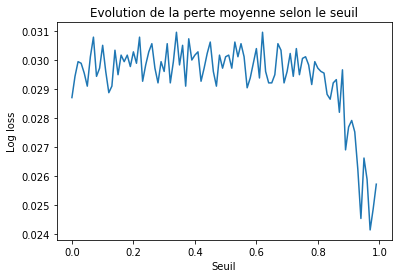

In [72]:
plt.plot(x,y)
plt.ylabel("Log loss")
plt.xlabel("Seuil")
plt.title("Evolution de la perte moyenne selon le seuil")
plt.show()

On obtient que le seuil optimal est 0.9, avec une perte logarithmique associée de 0.003.

In [75]:
x[np.argmin(y)]

0.96999999999999997

In [79]:
avg_logloss_cv(X=X97,Y=Y[HISTOLOGY],cv=kfold,classifier=LogR2)

0.024473455140685028

On calcule un score moyen sur 100 validations croisées de 99.8% de classifications correctes

In [80]:
avg_score_cv(X=X97,Y=Y[HISTOLOGY],cv=kfold,classifier=LogR2)

0.97479999999999978

On récupère les noms des sondes que l'on a gardé avec un seuil à 0.9

In [76]:
Index_97 = np.nonzero(seuil(C,x[97]))[0]
X97 = X.iloc[:,Index_97]

X.iloc[:,Index_97].dtypes.index.values

array(['A2M', 'ABCC5', 'ACTB', 'ACTG1', 'ACTN1', 'AFAP1-AS1', 'AHNAK',
       'ALDH1A1', 'ALDH1A3', 'ALDOA', 'ANXA1', 'ANXA2', 'ANXA5', 'AP2M1',
       'APLP2', 'APP', 'ARF1', 'ARF4', 'ARL6IP1', 'ATHL1', 'ATP13A3',
       'ATP2A2', 'B2M', 'BMS1P20', 'BPIFB1', 'C3', 'C7', 'CALD1', 'CALM2',
       'CALR', 'CALU', 'CANX', 'CAPN2', 'CD24', 'CD2AP', 'CD44', 'CD46',
       'CD55', 'CD59', 'CD63', 'CD74', 'CEACAM5', 'CEACAM6', 'CES1', 'CFB',
       'CGN', 'CLCA2', 'CLDN1', 'CLU', 'COL1A1', 'COL1A2', 'COL3A1',
       'COL4A2', 'COL5A2', 'COL6A3', 'CP', 'CPD', 'CSTA', 'CTSB', 'CTSC',
       'CTSD', 'DAP', 'DHCR24', 'DIO2', 'DNAJC10', 'DPYSL3', 'DSG2', 'DSP',
       'EEF1A1', 'EEF1G', 'EIF4G1', 'EIF4G2', 'EMP1', 'ENO1', 'EPHX1',
       'ERBB3', 'ERRFI1', 'F11R', 'FABP7', 'FAT2', 'FBL', 'FBN2', 'FGA',
       'FGFR2', 'FGG', 'FKBP9', 'FN1', 'FSTL1', 'FTH1', 'FTL', 'FXYD3',
       'GABRP', 'GAPDH', 'GM2A', 'GNB2L1', 'GOLM1', 'GPC3', 'GPCPD1',
       'GPNMB', 'H1F0', 'HLA-A', 'HLA-B', 'HLA-C', 'HLA-

In [6]:
def score_cv(X=None,Y=None,classifier=None,cv=None):
    kf = cv.split(X,Y)
    score = 0
    for i in range(cv.get_n_splits()):
        IndexTrain,IndexTest = next(kf)
        Xtrain,Ytrain = X.iloc[IndexTrain],Y.iloc[IndexTrain]
        Xtest,Ytest = X.iloc[IndexTest],Y.iloc[IndexTest]
        classifier.fit(Xtrain,Ytrain)
        score += classifier.score(Xtest,Ytest)
    return score/cv.get_n_splits()

In [7]:
def avg_score_cv(X=None,Y=None,classifier=None,cv=None,N=100):
    moy = 0
    for i in range(N):
        moy += score_cv(X,Y,classifier,cv)
    return moy/N

In [103]:
def stat_logloss_cv(X=None,Y=None,classifier=None,cv=None,N=100):
    l = []
    for i in range(N):
        l.append(logloss_cv(X,Y,classifier,cv))
    moyenne = np.mean(l)
    variance = np.mean((l-moyenne)**2)
    return moyenne,variance

In [4]:
def logloss_cv(X=None,Y=None,classifier=None,cv=None):
    kf = cv.split(X,Y)
    loss = 0
    for i in range(cv.get_n_splits()):
        IndexTrain,IndexTest = next(kf)
        Xtrain,Ytrain = X.iloc[IndexTrain],Y.iloc[IndexTrain]
        Xtest,Ytest = X.iloc[IndexTest],Y.iloc[IndexTest]
        classifier.fit(Xtrain,Ytrain)
        loss += log_loss(Ytest,classifier.predict(Xtest))
    return loss/X.shape[0]

In [5]:
def avg_logloss_cv(X=None,Y=None,classifier=None,cv=None,N=100):
    moy = 0
    for i in range(N):
        moy += logloss_cv(X,Y,classifier,cv)
    return moy/N

## Prédiction du taux de survie à n mois

In [11]:
from sklearn.linear_model import Lasso

### Base epilung

In [12]:
base = "epilung"

#### n=12 mois

In [13]:
nmois = 12

In [14]:
X = pd.read_csv(base+rf'/X_classification-{nmois}.csv',index_col=0)
Y = pd.read_csv(base+rf'/Y_classification-{nmois}.csv',index_col=0,header=None)

kfold = KFold(n_splits = 5,shuffle=True)

LogR2 = LogisticRegression(penalty="l2",C=1.0)
LogR1 = LogisticRegression(penalty="l1",C=1.0)

On commence par se donner une idée des scores de base

In [76]:
avg_logloss_cv(X=X,Y=Y[1],cv=kfold,classifier=LogR2)

0.13202444932052301

In [77]:
avg_score_cv(X=X,Y=Y[1],cv=kfold,classifier=LogR2)

0.77695616598480433

In [78]:
avg_logloss_cv(X=X,Y=Y[1],cv=kfold,classifier=LogR1)

0.12638496955395132

In [79]:
avg_score_cv(X=X,Y=Y[1],cv=kfold,classifier=LogR1)

0.78690531852717771

Influence de $C$ sur la feature selection

##### Feature selection

In [19]:
def get_important_parameters(X,Y,classifier):
    kfold = KFold(n_splits=5,shuffle=True)
    coefs = np.zeros(X.shape[1])
    for k in range(100):
        #print(f"{k}%")
        kf = kfold.split(X,Y)
        for i in range(5):
            IndexTrain,IndexTest = next(kf)
            Xtrain,Ytrain = X.iloc[IndexTrain],Y.iloc[IndexTrain]
            Xtest,Ytest = X.iloc[IndexTest],Y.iloc[IndexTest]
            classifier.fit(Xtrain,Ytrain)
            index = np.nonzero(classifier.coef_)[1]
            coefs[index]+=1/500
    return coefs

TODO : Comparer la feature selection avec $C=0.05$ et $C=1$

$C=1$

In [54]:
C = 1.0
LogR1 = LogisticRegression(penalty='l1',C=C)
LogR2 = LogisticRegression(penalty='l2',C=C)

In [ ]:
x,y = select_features(X,Y[1],logR1,logR2)

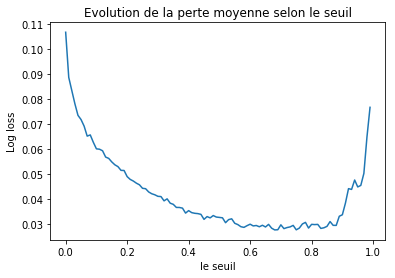

In [31]:
display_evol_erreur(x,y,"le seuil")

In [29]:
x[np.argmin(y)]

0.68000000000000005

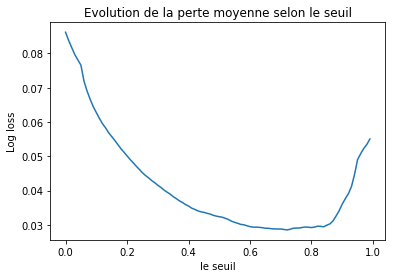

In [56]:
fenetre = 5
ym = moyennage(y,fenetre)
display_evol_erreur(x,ym,"le seuil")

In [33]:
x[np.argmin(ym)]

0.71999999999999997

In [34]:
Index_op = np.nonzero(seuil(coefs,x[np.argmin(ym)]))[0]
XOP = X.iloc[:,Index_op]

In [39]:
avg_logloss_cv(X=XOP,Y=Y[1],cv=kfold,classifier=LogR2)

0.028443247872131039

In [40]:
avg_score_cv(X=XOP,Y=Y[1],cv=kfold,classifier=LogR2)

0.95232261835184095

In [65]:
Plt = pd.read_csv("epilung/epilung_platform-refined.csv",index_col=0)
Plt.loc[XOP.columns.values]

,GB_ACC,Gene Symbol,ENTREZ_GENE_ID,RefSeq Transcript ID
id,,,,
1552390_a_at,NM_173549,C8orf47,203111,NM_001170806 /// NM_173549
1552626_a_at,NM_030923,TMEM163,81615,NM_030923
1554242_a_at,BC007230,COCH,1690,NM_001135058 /// NM_004086
1555236_a_at,BC042578,PGC,5225,NM_001166424 /// NM_002630
1555758_a_at,AF213040,CDKN3,1033,NM_001130851 /// NM_005192
1555765_a_at,AF493872,GNG4,2786,NM_001098721 /// NM_001098722 /// NM_004485
1555778_a_at,AY140646,POSTN,10631,NM_001135934 /// NM_001135935 /// NM_001135936...
1555867_at,BM666010,GNG4,2786,NM_001098721 /// NM_001098722 /// NM_004485
1558308_at,AK090616,LOC100292680,100292680,NR_028415


In [55]:
XOP.to_csv(rf'epilung/X_classification-{nmois}-{C}.csv')

$C=0.157$

In [54]:
C = 0.157
LogR1 = LogisticRegression(penalty='l1',C=C)
LogR2 = LogisticRegression(penalty='l2',C=C)

In [ ]:
x,y = select_features(X,Y[1],logR1,logR2)

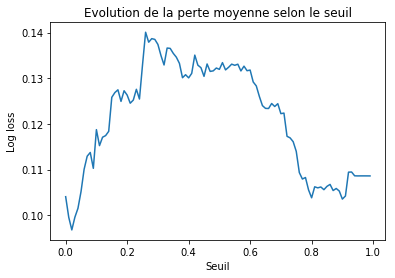

In [38]:
display_evol_erreur(x,y,"le seuil")

In [58]:
x[np.argmin(y)]

0.02

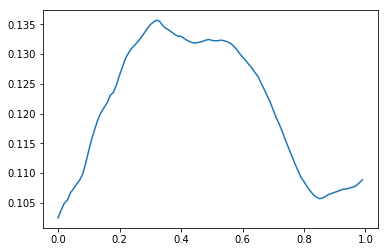

In [43]:
fenetre = 7
ym = moyennage(y,7)
display_evol_erreur(x,ym,'le seuil')

In [58]:
x[np.argmin(ym)]

0.02

In [47]:
Index_op = np.nonzero(seuil(coefs,x[np.argmin(ym)]))[0]
XOP = X.iloc[:,Index_op]

In [39]:
avg_logloss_cv(X=XOP,Y=Y[1],cv=kfold,classifier=LogR2)

0.028443247872131039

In [40]:
avg_score_cv(X=XOP,Y=Y[1],cv=kfold,classifier=LogR2)

0.95232261835184095

In [65]:
Plt = pd.read_csv("epilung/epilung_platform-refined.csv",index_col=0)
Plt.loc[XOP.columns.values]

,GB_ACC,Gene Symbol,ENTREZ_GENE_ID,RefSeq Transcript ID
id,,,,
1552390_a_at,NM_173549,C8orf47,203111,NM_001170806 /// NM_173549
1552626_a_at,NM_030923,TMEM163,81615,NM_030923
1554242_a_at,BC007230,COCH,1690,NM_001135058 /// NM_004086
1555236_a_at,BC042578,PGC,5225,NM_001166424 /// NM_002630
1555758_a_at,AF213040,CDKN3,1033,NM_001130851 /// NM_005192
1555765_a_at,AF493872,GNG4,2786,NM_001098721 /// NM_001098722 /// NM_004485
1555778_a_at,AY140646,POSTN,10631,NM_001135934 /// NM_001135935 /// NM_001135936...
1555867_at,BM666010,GNG4,2786,NM_001098721 /// NM_001098722 /// NM_004485
1558308_at,AK090616,LOC100292680,100292680,NR_028415


In [55]:
XOP.to_csv(rf'epilung/X_classification-{nmois}-{C}.csv')

##### Recherche de paramètre

On cherche la valeur optimale de $C$ pour la pénalisation $l_2$

In [81]:
import itertools

In [88]:
for k in itertools.product(C_val,C_val):
    print(k)

(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(1, 13)
(1, 14)
(1, 15)
(1, 16)
(1, 17)
(1, 18)
(1, 19)
(1, 20)
(1, 21)
(1, 22)
(1, 23)
(1, 24)
(1, 25)
(1, 26)
(1, 27)
(1, 28)
(1, 29)
(1, 30)
(1, 31)
(1, 32)
(1, 33)
(1, 34)
(1, 35)
(1, 36)
(1, 37)
(1, 38)
(1, 39)
(1, 40)
(1, 41)
(1, 42)
(1, 43)
(1, 44)
(1, 45)
(1, 46)
(1, 47)
(1, 48)
(1, 49)
(1, 50)
(1, 51)
(1, 52)
(1, 53)
(1, 54)
(1, 55)
(1, 56)
(1, 57)
(1, 58)
(1, 59)
(1, 60)
(1, 61)
(1, 62)
(1, 63)
(1, 64)
(1, 65)
(1, 66)
(1, 67)
(1, 68)
(1, 69)
(1, 70)
(1, 71)
(1, 72)
(1, 73)
(1, 74)
(1, 75)
(1, 76)
(1, 77)
(1, 78)
(1, 79)
(1, 80)
(1, 81)
(1, 82)
(1, 83)
(1, 84)
(1, 85)
(1, 86)
(1, 87)
(1, 88)
(1, 89)
(1, 90)
(1, 91)
(1, 92)
(1, 93)
(1, 94)
(1, 95)
(1, 96)
(1, 97)
(1, 98)
(1, 99)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(2, 13)
(2, 14)
(2, 15)
(2, 16)
(2, 17)
(2, 18)
(2, 19)
(2, 20)
(2, 21)
(2, 22)
(2, 23)
(2, 24)
(2, 25)
(2, 26)
(2, 27)
(2, 28)
(2

(19, 21)
(19, 22)
(19, 23)
(19, 24)
(19, 25)
(19, 26)
(19, 27)
(19, 28)
(19, 29)
(19, 30)
(19, 31)
(19, 32)
(19, 33)
(19, 34)
(19, 35)
(19, 36)
(19, 37)
(19, 38)
(19, 39)
(19, 40)
(19, 41)
(19, 42)
(19, 43)
(19, 44)
(19, 45)
(19, 46)
(19, 47)
(19, 48)
(19, 49)
(19, 50)
(19, 51)
(19, 52)
(19, 53)
(19, 54)
(19, 55)
(19, 56)
(19, 57)
(19, 58)
(19, 59)
(19, 60)
(19, 61)
(19, 62)
(19, 63)
(19, 64)
(19, 65)
(19, 66)
(19, 67)
(19, 68)
(19, 69)
(19, 70)
(19, 71)
(19, 72)
(19, 73)
(19, 74)
(19, 75)
(19, 76)
(19, 77)
(19, 78)
(19, 79)
(19, 80)
(19, 81)
(19, 82)
(19, 83)
(19, 84)
(19, 85)
(19, 86)
(19, 87)
(19, 88)
(19, 89)
(19, 90)
(19, 91)
(19, 92)
(19, 93)
(19, 94)
(19, 95)
(19, 96)
(19, 97)
(19, 98)
(19, 99)
(20, 1)
(20, 2)
(20, 3)
(20, 4)
(20, 5)
(20, 6)
(20, 7)
(20, 8)
(20, 9)
(20, 10)
(20, 11)
(20, 12)
(20, 13)
(20, 14)
(20, 15)
(20, 16)
(20, 17)
(20, 18)
(20, 19)
(20, 20)
(20, 21)
(20, 22)
(20, 23)
(20, 24)
(20, 25)
(20, 26)
(20, 27)
(20, 28)
(20, 29)
(20, 30)
(20, 31)
(20, 32)
(20, 33)
(

(48, 2)
(48, 3)
(48, 4)
(48, 5)
(48, 6)
(48, 7)
(48, 8)
(48, 9)
(48, 10)
(48, 11)
(48, 12)
(48, 13)
(48, 14)
(48, 15)
(48, 16)
(48, 17)
(48, 18)
(48, 19)
(48, 20)
(48, 21)
(48, 22)
(48, 23)
(48, 24)
(48, 25)
(48, 26)
(48, 27)
(48, 28)
(48, 29)
(48, 30)
(48, 31)
(48, 32)
(48, 33)
(48, 34)
(48, 35)
(48, 36)
(48, 37)
(48, 38)
(48, 39)
(48, 40)
(48, 41)
(48, 42)
(48, 43)
(48, 44)
(48, 45)
(48, 46)
(48, 47)
(48, 48)
(48, 49)
(48, 50)
(48, 51)
(48, 52)
(48, 53)
(48, 54)
(48, 55)
(48, 56)
(48, 57)
(48, 58)
(48, 59)
(48, 60)
(48, 61)
(48, 62)
(48, 63)
(48, 64)
(48, 65)
(48, 66)
(48, 67)
(48, 68)
(48, 69)
(48, 70)
(48, 71)
(48, 72)
(48, 73)
(48, 74)
(48, 75)
(48, 76)
(48, 77)
(48, 78)
(48, 79)
(48, 80)
(48, 81)
(48, 82)
(48, 83)
(48, 84)
(48, 85)
(48, 86)
(48, 87)
(48, 88)
(48, 89)
(48, 90)
(48, 91)
(48, 92)
(48, 93)
(48, 94)
(48, 95)
(48, 96)
(48, 97)
(48, 98)
(48, 99)
(49, 1)
(49, 2)
(49, 3)
(49, 4)
(49, 5)
(49, 6)
(49, 7)
(49, 8)
(49, 9)
(49, 10)
(49, 11)
(49, 12)
(49, 13)
(49, 14)
(49, 15)


(77, 3)
(77, 4)
(77, 5)
(77, 6)
(77, 7)
(77, 8)
(77, 9)
(77, 10)
(77, 11)
(77, 12)
(77, 13)
(77, 14)
(77, 15)
(77, 16)
(77, 17)
(77, 18)
(77, 19)
(77, 20)
(77, 21)
(77, 22)
(77, 23)
(77, 24)
(77, 25)
(77, 26)
(77, 27)
(77, 28)
(77, 29)
(77, 30)
(77, 31)
(77, 32)
(77, 33)
(77, 34)
(77, 35)
(77, 36)
(77, 37)
(77, 38)
(77, 39)
(77, 40)
(77, 41)
(77, 42)
(77, 43)
(77, 44)
(77, 45)
(77, 46)
(77, 47)
(77, 48)
(77, 49)
(77, 50)
(77, 51)
(77, 52)
(77, 53)
(77, 54)
(77, 55)
(77, 56)
(77, 57)
(77, 58)
(77, 59)
(77, 60)
(77, 61)
(77, 62)
(77, 63)
(77, 64)
(77, 65)
(77, 66)
(77, 67)
(77, 68)
(77, 69)
(77, 70)
(77, 71)
(77, 72)
(77, 73)
(77, 74)
(77, 75)
(77, 76)
(77, 77)
(77, 78)
(77, 79)
(77, 80)
(77, 81)
(77, 82)
(77, 83)
(77, 84)
(77, 85)
(77, 86)
(77, 87)
(77, 88)
(77, 89)
(77, 90)
(77, 91)
(77, 92)
(77, 93)
(77, 94)
(77, 95)
(77, 96)
(77, 97)
(77, 98)
(77, 99)
(78, 1)
(78, 2)
(78, 3)
(78, 4)
(78, 5)
(78, 6)
(78, 7)
(78, 8)
(78, 9)
(78, 10)
(78, 11)
(78, 12)
(78, 13)
(78, 14)
(78, 15)
(78, 16)

In [165]:
def stat_logloss_cv(X=None,Y=None,classifier=None,cv=None,N=100):
    l = []
    for i in range(N):
        l.append(classifier.logloss())
    moyenne = np.mean(l)
    variance = np.mean((l-moyenne)**2)
    return moyenne,variance

In [181]:
def GridLoss(X,Y,classifier,arrays,params,cv,n_iter):
    perte = []
    variance = []
    for k in itertools.product(arrays):
        #print(f"{k}")
        for (p,v) in zip(params,k):
            classifier.objetSK.set_params(**{p:v})
        mu,var = stat_logloss_cv(X=X,Y=Y,cv=cv,classifier=classifier,N=n_iter)
        perte.append(mu)
        variance.append(var)
    return perte,variance

In [ ]:
C_val = np.arange(1.0,5000.0,1)
perte,variance = GridLoss(XOP,Y[1],LogR2,C_val,['C'],kfold,10)

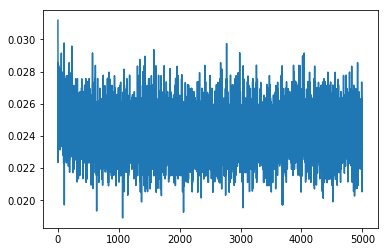

In [170]:
display_evol(C_val,perte)

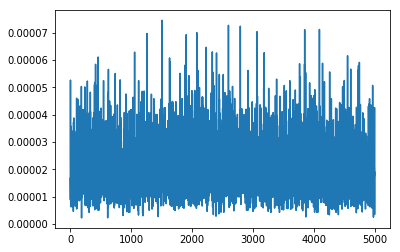

In [171]:
display_evol(C_val,variance)

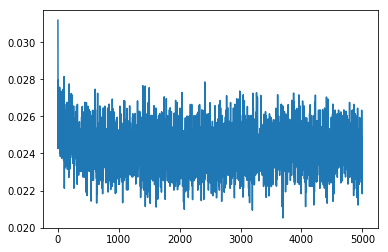

In [180]:
ym = moyennage(perte,1)
display_evol(C_val,ym)

#### n=60 mois

In [10]:
nmois = 60

In [11]:
base = 'epilung'

In [24]:
X = pd.read_csv(base+rf'/X_classification-{nmois}.csv',index_col=0)
Y = pd.read_csv(base+rf'/Y_classification-{nmois}.csv',index_col=0,header=None)

In [13]:
kfold = KFold(n_splits = 5,shuffle=True)

In [ ]:
LogR2 = Bite.LinearClassifieur(LogisticRegression(penalty='l2',C=1.0),nmois,kfold,X=X,Y=Y[1])
LogR1 = Bite.LinearClassifieur(LogisticRegression(penalty="l1",C=1.0),nmois,kfold,X=X,Y=Y[1])

On commence par se donner une idée des scores de base

In [ ]:
LogR2.stat_logloss()

In [ ]:
LogR2.stat_score()

In [ ]:
LogR1.stat_logloss()

In [ ]:
LogR1.stat_score()

In [23]:
def display_evol_erreur(x,y,parameter_name):
    plt.plot(x,y)
    plt.ylabel("Log loss")
    plt.xlabel(f"{parameter_name}")
    plt.title(f"Evolution de la perte moyenne selon {parameter_name}")
    plt.show()

In [21]:
def erreur_seuil(x,classifier):
    y = []
    for k in x:
        Index_k = np.nonzero(seuil(coefs,k))[0]
        Xk = X.iloc[:,Index_k]
        y.append(avg_logloss_cv(X=Xk,Y=Y[1],cv=kfold,classifier=classifier))
    return y

In [22]:
def erreur_C(X,Y,C_val,classifier,cv):
    perte = []
    for C in C_val:
        classifier.set_params(C=C)
        perte.append(avg_logloss_cv(X=X,Y=Y,cv=cv,classifier=classifier))
    return perte

#### Feature selection

In [50]:
from timeit import default_timer as timer

In [20]:
def moyennage(signal,taille_fenetre):
    sortie = []
    n = len(signal)
    for i in range(n):
        fenetre = signal[max(0,i-taille_fenetre):min(n,i+taille_fenetre)]
        avg = sum(fenetre)
        sortie.append(avg/len(fenetre))
    return sortie

In [125]:
def display_evol(x,y,std=None,title="",xlabel="",ylabel="",):
    plt.plot(x,y)
    if std is not None:
        plt.fill_between(x,y+std,y-std,facecolor='yellow',alpha=0.5)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

In [23]:
def seuil(Array,S):
    f_s = lambda x: int(x > S)
    f = np.vectorize(f_s)
    return f(Array)

In [53]:
def select_features(X,Y,pourcentage,classifierTest,N=100):
    seuil_grid = np.arange(0,1,0.01)
    moy,var = classifierTest.stat_seuil(seuil_grid,pourcentage,X=X,Y=Y,N=N)
    return (x,y)

In [ ]:
percent,avg = LogR1.feature_relevance(100,0)

In [ ]:
Stats = pd.DataFrame(data={'pourcentage':percent,'moyenne':avg[0]},index=X.columns)

In [130]:
seuil_grid = np.arange(0.9,1.0,0.01)
moy,var,skipped = LogR2.stat_seuil(seuil_grid,Stats['pourcentage'].values,N=100)

In [128]:
std = 1.96*np.sqrt(var)

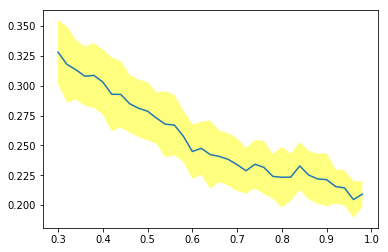

In [129]:
display_evol(seuil_grid,moy,std=std)

In [131]:
std = 1.96*np.sqrt(var)

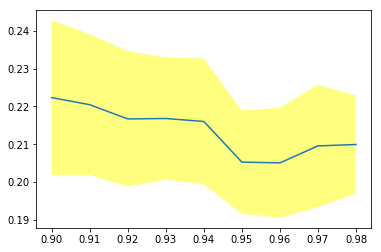

In [133]:
display_evol(seuil_grid[:-skipped],moy,std=std)

In [139]:
seuil_grid = np.arange(0.9,1.0,0.005)
moy,var,skipped = LogR2.stat_seuil(seuil_grid,Stats['pourcentage'].values,N=200)

In [140]:
std = 1.96*np.sqrt(var)

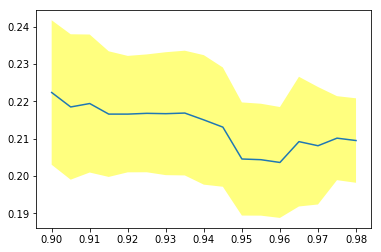

In [141]:
display_evol(seuil_grid[:-skipped],moy,std=std)

In [145]:
np.argmin(moy)

12

In [147]:
seuil_grid[12]

0.96000000000000008

In [148]:
Index_k = np.nonzero(seuil(Stats['pourcentage'],0.96))[0]
Xk = X.iloc[:,Index_k]

In [149]:
Xk.columns

Index(['200953_s_at', '203913_s_at', '204712_at', '205399_at', '205489_at',
       '220542_s_at', '40665_at'],
      dtype='object')

In [151]:
Stats['pourcentage'].loc[Xk.columns.values]

200953_s_at    0.980
203913_s_at    0.972
204712_at      0.970
205399_at      0.964
205489_at      0.984
220542_s_at    0.980
40665_at       0.984
Name: pourcentage, dtype: float64

In [150]:
Plt = pd.read_csv("epilung/epilung_platform-refined.csv",index_col=0)
Plt.loc[Xk.columns.values]

,GB_ACC,Gene Symbol,ENTREZ_GENE_ID,RefSeq Transcript ID
id,,,,
200953_s_at,NM_001759,CCND2,894,NM_001759
203913_s_at,AL574184,HPGD,3248,NM_000860 /// NM_001145816 /// NR_027332
204712_at,NM_007191,WIF1,11197,NM_007191
205399_at,NM_004734,DCLK1,9201,NM_001195415 /// NM_001195416 /// NM_001195430...
205489_at,NM_001888,CRYM,1428,NM_001014444 /// NM_001888
220542_s_at,NM_016583,PLUNC,51297,NM_016583 /// NM_130852
40665_at,M83772,FMO3,2328,NM_001002294 /// NM_006894


C

In [157]:
import itertools

In [173]:
C_val = np.arange(1.0,10.0,1.0)
perte,variance = GridLoss(Xk,Y[1],LogR2,C_val,['C'],kfold,10)

(0.10000000000000001,)
(0.20000000000000001,)
(0.30000000000000004,)
(0.40000000000000002,)
(0.5,)
(0.59999999999999998,)
(0.70000000000000007,)
(0.80000000000000004,)
(0.90000000000000002,)


In [174]:
std = 1.96*np.sqrt(variance)

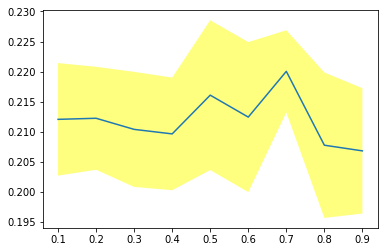

In [176]:
display_evol(C_val,perte,np.sqrt(variance))

In [177]:
C_val = np.arange(1.0,10.0,1.0)
perte,variance = GridLoss(Xk,Y[1],LogR2,C_val,['C'],kfold,10)

(1.0,)
(2.0,)
(3.0,)
(4.0,)
(5.0,)
(6.0,)
(7.0,)
(8.0,)
(9.0,)


In [178]:
std = 1.96*np.sqrt(variance)

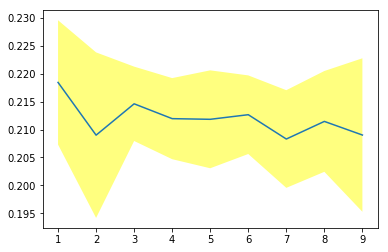

In [179]:
display_evol(C_val,perte,np.sqrt(variance))

In [ ]:
C_val = np.arange(1.0,100.0,1.0)
perte,variance = GridLoss(Xk,Y[1],LogR2,C_val,['C'],kfold,20)

In [ ]:
std = 1.96*np.sqrt(variance)

In [ ]:
display_evol(C_val,perte,np.sqrt(variance))

## Prédiction de la durée de survie

In [181]:
from sklearn.linear_model import Lasso

In [182]:
from sklearn.linear_model import Ridge

In [20]:
from sklearn.metrics import mean_squared_error,log_loss

### Base epilung

In [183]:
base = "epilung"

In [188]:
def distance_cv(X,Y,cv,classifier):
    kf = cv.split(X,Y)
    loss = 0
    for i in range(cv.get_n_splits()):
        IndexTrain,IndexTest = next(kf)
        Xtrain,Ytrain = X.iloc[IndexTrain],Y.iloc[IndexTrain]
        Xtest,Ytest = X.iloc[IndexTest],Y.iloc[IndexTest]
        classifier.fit(Xtrain,Ytrain)
        loss += mean_squared_error(Ytest,classifier.predict(Xtest))
    return loss/X.shape[0]

In [192]:
def stat_distance_cv(X,Y,cv,classifier,N=100):
    l=[]
    for i in range(N):
       l.append(distance_cv(X,Y,cv,classifier))
    moyenne = np.mean(l)
    variance = np.mean((l-moyenne)**2)
    return moyenne,variance

In [184]:
X = pd.read_csv(base+rf'/X_regression.csv',index_col=0)
Y = pd.read_csv(base+rf'/Y_regression.csv',index_col=0,header=None)

kfold = KFold(n_splits = 5,shuffle=True)

LinR2 = Ridge(alpha=1.0)
LinR1 = Lasso(alpha=1.0)

In [ ]:
from sklearn.metrics import mean_square_error

In [ ]:
from sklearn.metrics import mean_absolute_error

On commence par se donner une idée des scores de base

In [193]:
stat_distance_cv(X=X,Y=Y[1],cv=kfold,classifier=LinR2)

(66.244341890910377, 5.2548306580586424)

In [194]:
avg_score_cv(X=X,Y=Y[1],cv=kfold,classifier=LinR2)

-0.029771184524112267

In [195]:
stat_distance_cv(X=X,Y=Y[1],cv=kfold,classifier=LinR1)

/home/merlin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


KeyboardInterrupt: 

In [ ]:
stat_distance_cv(X=X,Y=Y[1],cv=kfold,classifier=LinR1)

##### Feature selection

In [54]:
alpha = 1.0
LinR1 = Lasso(alpha=alpha)
LinR2 = Ridge(alpha=alpha)

In [ ]:
x,y = select_features(X,Y[1],linR1,linR2)

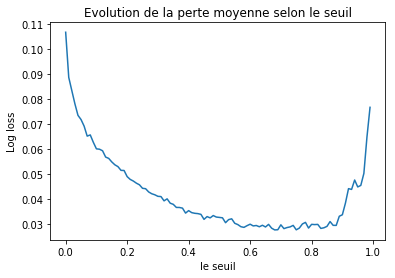

In [31]:
display_evol_erreur(x,y,"le seuil")

In [58]:
x[np.argmin(y)]

0.02

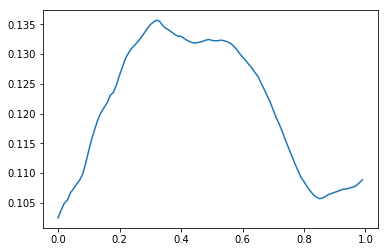

In [43]:
fenetre = 7
ym = moyennage(y,7)
display_evol_erreur(x,ym,'le seuil')

In [58]:
x[np.argmin(ym)]

0.02

In [47]:
Index_op = np.nonzero(seuil(coefs,x[np.argmin(ym)]))[0]
XOP = X.iloc[:,Index_op]

In [39]:
avg_logloss_cv(X=XOP,Y=Y[1],cv=kfold,classifier=LinR2)

0.028443247872131039

In [40]:
avg_score_cv(X=XOP,Y=Y[1],cv=kfold,classifier=LinR2)

0.95232261835184095

In [65]:
Plt = pd.read_csv("epilung/epilung_platform-refined.csv",index_col=0)
Plt.loc[XOP.columns.values]

,GB_ACC,Gene Symbol,ENTREZ_GENE_ID,RefSeq Transcript ID
id,,,,
1552390_a_at,NM_173549,C8orf47,203111,NM_001170806 /// NM_173549
1552626_a_at,NM_030923,TMEM163,81615,NM_030923
1554242_a_at,BC007230,COCH,1690,NM_001135058 /// NM_004086
1555236_a_at,BC042578,PGC,5225,NM_001166424 /// NM_002630
1555758_a_at,AF213040,CDKN3,1033,NM_001130851 /// NM_005192
1555765_a_at,AF493872,GNG4,2786,NM_001098721 /// NM_001098722 /// NM_004485
1555778_a_at,AY140646,POSTN,10631,NM_001135934 /// NM_001135935 /// NM_001135936...
1555867_at,BM666010,GNG4,2786,NM_001098721 /// NM_001098722 /// NM_004485
1558308_at,AK090616,LOC100292680,100292680,NR_028415


In [55]:
XOP.to_csv(rf'epilung/X_regression-{C}.csv')

## Modèles ensemblistes

### Random Forest